# TEST 0

In [1]:
from __future__ import absolute_import, division, print_function

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from config import *
from common import *
display.clear_output()

In [3]:
from affwild2_challenge.basic_emotion_v1.dataset_affwild2 import AffWild2Dataset, emotiw_affwild2_mapping, affwild2_name, affwild2_emotiw_mapping, emotiw_name
from affwild2_challenge.basic_emotion_v1.dataload_expr_va_image import VAExprImageBalancedDataLoader
from affwild2_challenge.basic_emotion_v1.datagen_expr_va  import VAExprDataGenerator

from affwild2_challenge.basic_emotion_v1.models.models_expr_image import EXPR_VA_IMAGE_V0

from affwild2_challenge.basic_emotion_v1.dataaug  import train_aug, valid_aug
from affwild2_challenge.basic_emotion_v1.dataaug  import vggface2_preprocessing_input, vggface2_postprocessing_input

from affwild2_challenge.basic_emotion_v1.losses import ccc, loss_ccc, ccc_numpy
from affwild2_challenge.basic_emotion_v1.metrics import expr_score, f1_score, concordance_cc2

## 1. Setup Environments

In [4]:
params = {}
params["results_dir"] = os.path.join(sub_dir, "results", "t12")

params["db_file"] = os.path.join(dataset_dir, "AffWild2/data/affwild2_cropped_frames_v1.h5")
params["db_root"] = os.path.join(dataset_dir, "AffWild2/data/cropped")

params["batch_size"] = 128
params["gpus"] = ["0"]
params["weights_path"] = os.path.join(sub_dir, "weights", "t12_affwild2_expr_va_image_weights_200222115759_epoch-31_loss-4.47_class-0.54_0.52_0.35_reg-0.04_0.02_0.12.h5")

params["debug"] = False
params["run_train"] = False
params["run_valid"] = True
params["run_test"] = False
params["run_test_va"] = True

params["val_train"] = False
params["val_valid"] = True

# params["n_blocks"]  = 16
params["use_parallel_model"] = True
params["max_queue_size"] = 22
params["workers"] = 16
params["use_multiprocessing"] = False


print("parameters: ")
for key in params.keys(): print("+ %s: %s"%(key,params[key]))

if os.path.exists(params["results_dir"]) == False: os.makedirs(params["results_dir"])

parameters: 
+ results_dir: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit1/results/t12
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_frames_v1.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped
+ batch_size: 128
+ gpus: ['0']
+ weights_path: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit1/weights/t12_affwild2_expr_va_image_weights_200222115759_epoch-31_loss-4.47_class-0.54_0.52_0.35_reg-0.04_0.02_0.12.h5
+ debug: False
+ run_train: False
+ run_valid: True
+ run_test: False
+ run_test_va: True
+ val_train: False
+ val_valid: True
+ use_parallel_model: True
+ max_queue_size: 22
+ workers: 16
+ use_multiprocessing: False


In [5]:
# Choose gpus, init session
choose_keras_environment(gpus = params["gpus"], keras_backend = "tensorflow", verbose = 1)
init_session()
check_tensorflow_environment()

Environment GPUs:
+ Choose GPUs:  0
+ Keras backend:  tensorflow


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1

TensorFlow Version: 1.15.0
Default GPU Device: /device:GPU:0


## 2. Setup Data

In [6]:
# Dataset Configuration
dataset_info  = dict(db_file = params["db_file"], db_root = params["db_root"])
print("dataset_info: ")
for key in dataset_info.keys(): print("+ %s: %s"%(key,dataset_info[key]))
    
ds = AffWild2Dataset(**dataset_info)
ds.load_scheme_emotion_va()

dataset_info: 
+ db_file: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/affwild2_cropped_frames_v1.h5
+ db_root: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/data/datasets/AffWild2/data/cropped
Loading Scheme Emotion VA: 
 + Loading train: 194
 + Loading valid: 57
 + Loading test: 223
 + Loading va_test: 139


Number of images:	721631
Distribution:  {'Neutral': 451062, 'Angry': 18470, 'Disgust': 7095, 'Fear': 9864, 'Happy': 116562, 'Sad': 85803, 'Surprise': 32775}


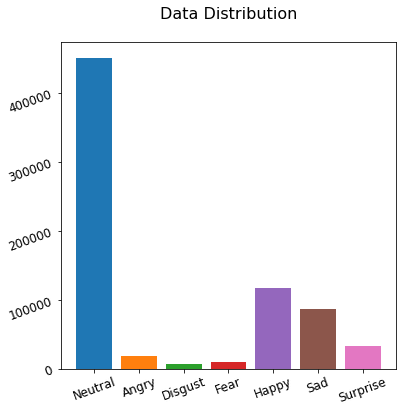

Number of images:	255683
Distribution:  {'Neutral': 156069, 'Angry': 6803, 'Disgust': 977, 'Fear': 8152, 'Happy': 36605, 'Sad': 31186, 'Surprise': 15891}


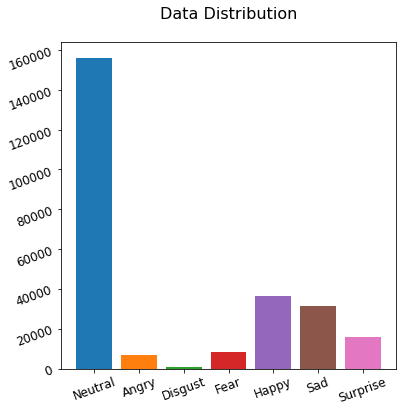

Number of images:	997326
Distribution:  {'Test': 997326}


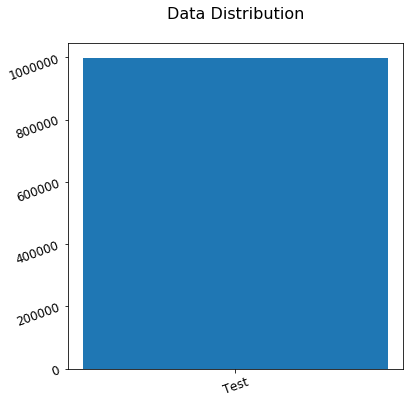

In [7]:
ds.view_emotion_summary(ds.a_idx_train, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_valid, figsize=(6,6))
ds.view_emotion_summary(ds.a_idx_test, figsize=(6,6));

Number of images:	721631
--------------------
Process va_valence: 
[0.148 0.148 0.148 ... 0.89  0.874 0.874]
Invalid distribution: Empty


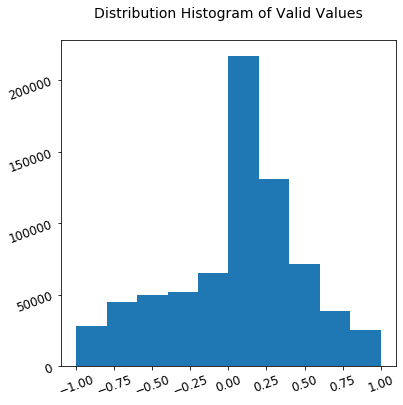

--------------------
Process va_arousal: 
[0.352 0.36  0.362 ... 0.874 0.874 0.874]
Invalid distribution: Empty


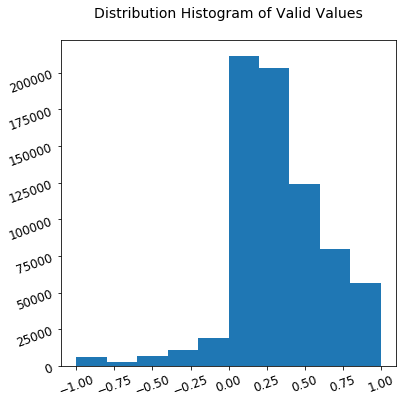

Number of images:	255683
--------------------
Process va_valence: 
[-1.    -1.    -1.    ... -0.942 -0.942 -0.942]
Invalid distribution: Empty


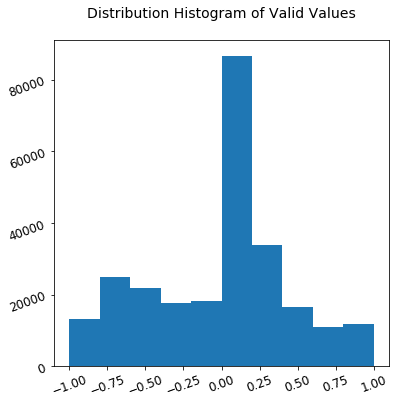

--------------------
Process va_arousal: 
[0.748 0.748 0.748 ... 0.705 0.683 0.689]
Invalid distribution: Empty


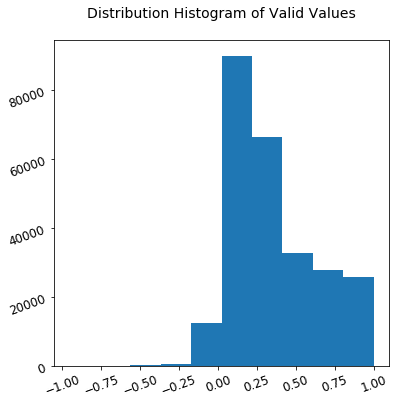

Number of images:	716665
--------------------
Process va_valence: 
[-2. -2. -2. ... -2. -2. -2.]
Invalid distribution:  {'Test': 716665}
Valid distribution: Empty
--------------------
Process va_arousal: 
[-2. -2. -2. ... -2. -2. -2.]
Invalid distribution:  {'Test': 716665}
Valid distribution: Empty


In [8]:
ds.view_va_summary(ds.a_idx_train, figsize=(6,6))
ds.view_va_summary(ds.a_idx_valid, figsize=(6,6))
ds.view_va_summary(ds.a_idx_va_test, figsize=(6,6))

In [9]:
train_loader = VAExprImageBalancedDataLoader(ds.a_idx_train, ds, 
                                    n_classes = 7,
                                    transforms= valid_aug(224),
                                    mode = "train", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

valid_loader = VAExprImageBalancedDataLoader(ds.a_idx_valid, ds, 
                                    n_classes = 7,
                                    transforms= valid_aug(224),
                                    mode = "valid", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

test_loader = VAExprImageBalancedDataLoader(ds.a_idx_test, ds, 
                                    n_classes = 7,
                                    transforms= valid_aug(224),
                                    mode = "test", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

test_va_loader = VAExprImageBalancedDataLoader(ds.a_idx_va_test, ds, 
                                    n_classes = 7,
                                    transforms= valid_aug(224),
                                    mode = "test", 
                                    has_balance=False, 
                                    balanced_mode = "", 
                                    capacity = 0,  
                                    preprocessing_image_fn = None)

Training


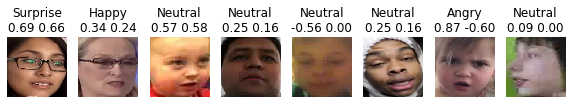

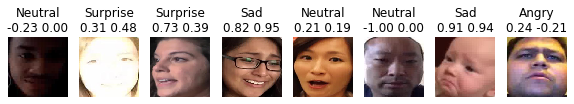

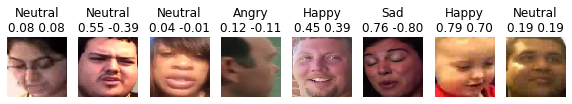

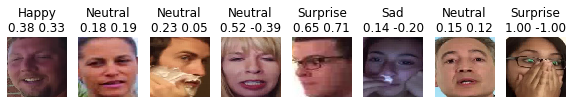

Validating


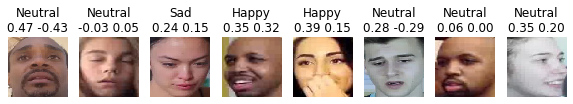

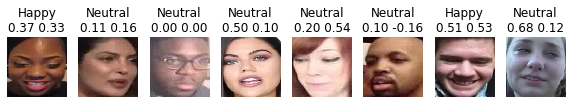

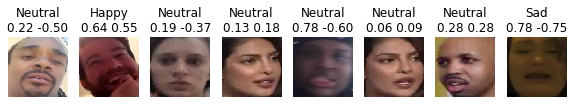

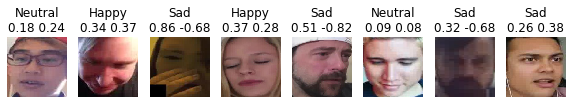

Testing


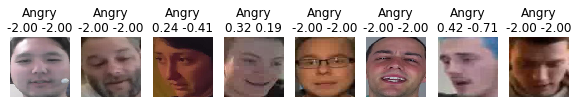

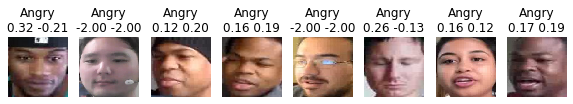

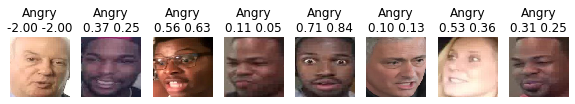

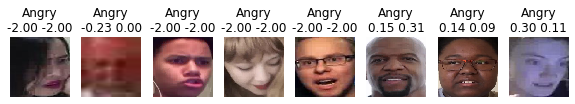

Testing VA


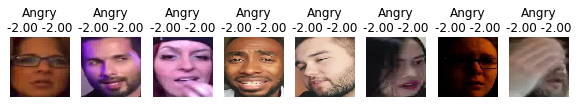

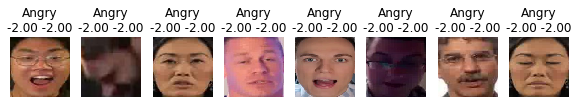

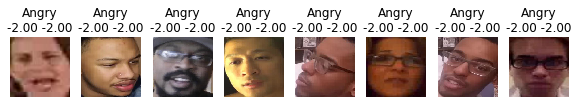

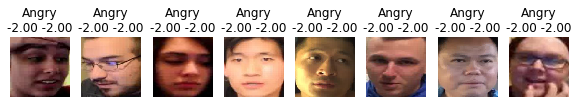

In [10]:
print("Training")
train_loader.view_images()
print("Validating")
valid_loader.view_images()
print("Testing")
test_loader.view_images()
print("Testing VA")
test_va_loader.view_images()

In [11]:
train_gen = VAExprDataGenerator(dataloader = train_loader, 
                                preprocessing_image_fn = vggface2_preprocessing_input,
                                batch_size = params["batch_size"], 
                                shuffle = False, seed = None )
print("Train: ")
x, y = next(train_gen)
print(x.shape, np.min(x), np.max(x))
print(y[0].shape, y[1].shape, y[2].shape)

valid_gen = VAExprDataGenerator(dataloader = valid_loader, 
                                preprocessing_image_fn = vggface2_preprocessing_input,
                                batch_size = params["batch_size"], 
                                shuffle = False, seed = None )
print("Valid: ")
x, y = next(valid_gen)
print(x.shape, np.min(x), np.max(x))
print(y[0].shape, y[1].shape, y[2].shape)

test_gen = VAExprDataGenerator(dataloader = test_loader, 
                                preprocessing_image_fn = vggface2_preprocessing_input,
                                batch_size = params["batch_size"], 
                                shuffle = False, seed = None )
print("Test: ")
x, y = next(test_gen)
print(x.shape, y)

test_va_gen = VAExprDataGenerator(dataloader = test_va_loader, 
                                preprocessing_image_fn = vggface2_preprocessing_input,
                                batch_size = params["batch_size"], 
                                shuffle = False, seed = None )
print("Test: ")
x, y = next(test_va_gen)
print(x.shape, y)

Train: 
(128, 224, 224, 3) -114.0912 163.5047
(128, 7) (128, 1) (128, 1)
Valid: 
(128, 224, 224, 3) -131.0912 92.5047
(128, 7) (128, 1) (128, 1)
Test: 
(128, 224, 224, 3) None
Test: 
(128, 224, 224, 3) None


## 3. Setup Model

In [12]:
if params["run_train"]==True or params["run_valid"]==True or params["run_test"]==True or params["run_test_va"] == True:
    # Load Model
    K.clear_session()
    model = load_model(params["weights_path"], custom_objects={"loss_ccc": loss_ccc, 
                                                               "ccc": ccc, 
                                                               "f1_score": f1_score, 
                                                               "expr_score": expr_score})
    display.clear_output()
    print("Weight path: ", params["weights_path"])
    # Model Summary
    model.summary()
    
    if params["use_parallel_model"] == True and len(params["gpus"])>=2:
        model = multi_gpu_model(model, gpus = len(params["gpus"]))
    # if
# if

Weight path:  /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit1/weights/t12_affwild2_expr_va_image_weights_200222115759_epoch-31_loss-4.47_class-0.54_0.52_0.35_reg-0.04_0.02_0.12.h5
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2048)         27757504    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           model_1[1][0]                    
________________________________________________________________________________________________

## 4. Predict

### 4.1. Train

In [13]:
if params["run_train"] == True:
    train_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(train_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                  
    else:
        y_pred = model.predict(train_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                  
    # if
# if

In [14]:
if params["run_train"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], "train.npz")
    print(f"Save Train: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.2. Valid

In [15]:
if params["run_valid"] == True:
    valid_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(valid_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                  
    else:
        y_pred = model.predict(valid_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                  
    # if
# if

1998/1998 [==============================] - 508s 254ms/step


In [16]:
if params["run_valid"] == True:
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], "valid.npz")
    print(f"Save Valid: {save_path}")
    np.savez(save_path, **y_results)
# if

Save Valid: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit1/results/t12/valid.npz


### 4.3. Test

In [17]:
if params["run_test"] == True:    
    test_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(test_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                  
    else:
        y_pred = model.predict(test_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                  
# if

In [18]:
if params["run_test"] == True:    
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], "test.npz")
    print(f"Save Test: {save_path}")
    np.savez(save_path, **y_results)
# if

### 4.4. Test VA

In [19]:
if params["run_test_va"] == True:    
    test_va_gen.reset()

    if params["debug"] == True:
        steps = 50
        y_pred = model.predict(test_va_gen, steps = steps,
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                  
    else:
        y_pred = model.predict(test_va_gen, 
                               verbose = 1,
                               max_queue_size=params["max_queue_size"], 
                               workers=params["workers"], 
                               use_multiprocessing=params["use_multiprocessing"])                                  
# if

5599/5599 [==============================] - 1413s 252ms/step


In [20]:
if params["run_test_va"] == True:    
    y_results = {}
    y_results["emotion"]    = y_pred[0]
    y_results["aro_ccc"]    = y_pred[1]
    y_results["val_ccc"]    = y_pred[2]
    y_results["valaro_mse"] = y_pred[3]

    save_path = os.path.join(params["results_dir"], "test_va.npz")
    print(f"Save Test: {save_path}")
    np.savez(save_path, **y_results)
# if

Save Test: /home/pc/Documents/dntai/projects/Emotion/AffWild2Prj/submit1/results/t12/test_va.npz


## 5. Evaluation

### 5.1. Train

In [21]:
if params["val_train"] == True:   
    
    load_path  = os.path.join(params["results_dir"], f"train.npz")
    a_idx_data = ds.a_idx_train

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
    
    aro_pred = y_results["aro_ccc"].flatten()
    val_pred = y_results["val_ccc"].flatten()
    aro_true = ds.df_frames.loc[a_idx_data]["va_arousal"].values
    val_true = ds.df_frames.loc[a_idx_data]["va_valence"].values

    aro_ccc1 = concordance_cc2(aro_true, aro_pred)
    aro_ccc2 = ccc_numpy(aro_true, aro_pred)
    val_ccc1 = concordance_cc2(val_true, val_pred)
    val_ccc2 = ccc_numpy(val_true, val_pred)

    avg_ccc1 = (aro_ccc1 + val_ccc1) / 2.0
    avg_ccc2 = (aro_ccc2 + val_ccc2) / 2.0

    print(f"aro: {aro_ccc1}, {aro_ccc2}")
    print(f"val: {val_ccc1}, {val_ccc2}")
    print(f"valaro_avg: {avg_ccc1}, {avg_ccc2}")
# if

## 5.2. Valid

Classification Report: 
               precision    recall  f1-score   support

     Neutral       0.83      0.25      0.38    156069
       Angry       0.12      0.36      0.18      6803
     Disgust       0.05      0.27      0.08       977
        Fear       0.09      0.09      0.09      8152
       Happy       0.41      0.76      0.53     36605
         Sad       0.36      0.69      0.47     31186
    Surprise       0.21      0.63      0.32     15891

    accuracy                           0.40    255683
   macro avg       0.29      0.43      0.29    255683
weighted avg       0.63      0.40      0.39    255683

Confustion Matrix Int: 
 [[38552 14380  2671  6448 35487 27205 31326]
 [  456  2424    88    65   496  2878   396]
 [   43   166   266     5   195   149   153]
 [  596   519   806   711   374  3816  1330]
 [ 1550   315   140   119 27643  4002  2836]
 [ 3721   646  1567   610  2123 21517  1002]
 [ 1441  1344   282   243  1653   987  9941]]

Confustion Matrix Norm: 
 [[24.7   9

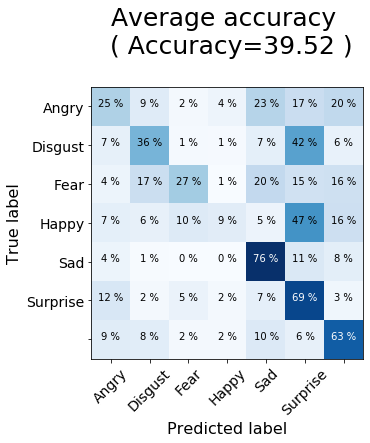

In [22]:
if params["val_valid"] == True:   
    load_path  = os.path.join(params["results_dir"], f"valid.npz")
    a_idx_data = ds.a_idx_valid

    y_results = dict(np.load(load_path, allow_pickle=True))
    
    y_pred_emotion_label = emotiw_affwild2_mapping[np.argmax(y_results["emotion"], axis = 1)]
    y_true_emotion_label = ds.df_frames.loc[a_idx_data]["expr_emotion"].values
    
    a_summary_report = model_report(y_true_emotion_label, y_pred_emotion_label, affwild2_name)
    s_summary_report = buffer_print_string(print_summary, a_summary_report)
    print(s_summary_report)
    
    f1   = a_summary_report["model_f1_avg_weighted"]
    acc  = a_summary_report["model_acc_all"]
    expr = f1 * 0.66 + acc * 0.33
    print(f"f1: {f1}")
    print(f"acc: {acc}")
    print(f"expr: {expr}")
    
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(y_true_emotion_label, y_pred_emotion_label, 
                          title='Average accuracy \n ( Accuracy={acc:.2f} )\n',
                          classes = affwild2_name)
    
    aro_pred = y_results["aro_ccc"].flatten()
    val_pred = y_results["val_ccc"].flatten()
    aro_true = ds.df_frames.loc[a_idx_data]["va_arousal"].values
    val_true = ds.df_frames.loc[a_idx_data]["va_valence"].values

    aro_ccc1 = concordance_cc2(aro_true, aro_pred)
    aro_ccc2 = ccc_numpy(aro_true, aro_pred)
    val_ccc1 = concordance_cc2(val_true, val_pred)
    val_ccc2 = ccc_numpy(val_true, val_pred)

    avg_ccc1 = (aro_ccc1 + val_ccc1) / 2.0
    avg_ccc2 = (aro_ccc2 + val_ccc2) / 2.0

    print(f"aro: {aro_ccc1}, {aro_ccc2}")
    print(f"val: {val_ccc1}, {val_ccc2}")
    print(f"valaro_avg: {avg_ccc1}, {avg_ccc2}")
# if